In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = Path.cwd() / "ravdess" / "emotional-speech-audio"
SAMPLE_RATE = 48000

data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/kaggle/input/',dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        data = data.append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )

In [3]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 1440


,Emotion,Emotion intensity,Gender,Path
0,1,normal,male,C:\Users\Burlay\Desktop\bda_ml\ravdess\emotion...
1,1,normal,female,C:\Users\Burlay\Desktop\bda_ml\ravdess\emotion...
2,1,normal,male,C:\Users\Burlay\Desktop\bda_ml\ravdess\emotion...
3,1,normal,female,C:\Users\Burlay\Desktop\bda_ml\ravdess\emotion...
4,1,normal,male,C:\Users\Burlay\Desktop\bda_ml\ravdess\emotion...


Text(0, 0.5, 'Number of examples')

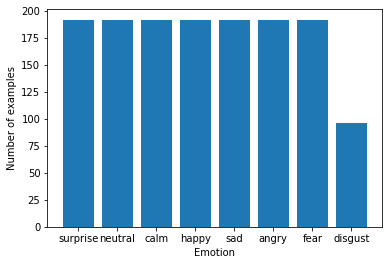

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotion')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

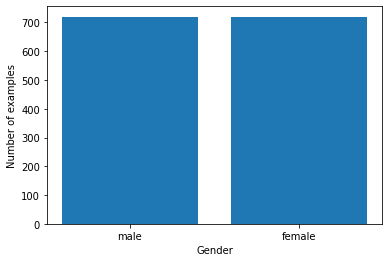

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

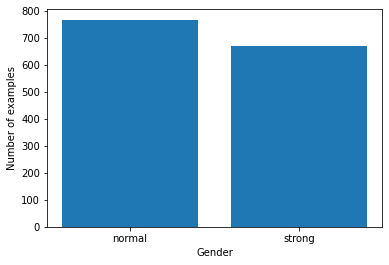

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Emotion intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

## Load the signals

In [7]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

 Processed 1439/1440 files

## Split the data

In [8]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(1147, 144000), Y_train:(1147,)
X_val:(143, 144000), Y_val:(143,)
X_test:(150, 144000), Y_test:(150,)
Number of unique indexes is 1440, out of 1440


## Augment signals by adding AWGN

In [9]:

def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [10]:
aug_signals = []
aug_labels = []
for i in range(X_train.shape[0]):
    signal = X_train[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(data.loc[i,"Emotion"])
        aug_signals.append(augmented_signals[j,:])
        data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_train = np.concatenate([X_train,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
Y_train = np.concatenate([Y_train,aug_labels])
print('')
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')

 Processed 1146/1147 files
X_train:(3441, 144000), Y_train:(3441,)


## Calculate mel spectrograms

c:\users\burlay\desktop\bda_ml\venv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\burlay\desktop\bda_ml\venv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


MEL spectrogram shape:  (128, 563)


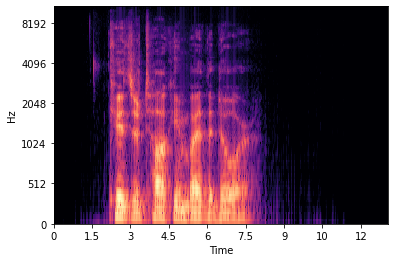

In [11]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [12]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
del X_train

mel_val = []
print("Calculatin mel spectrograms for val set")
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
del X_val

mel_test = []
print("Calculatin mel spectrograms for test set")
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
del X_test

Calculatin mel spectrograms for train set
 Processed 3440/3441 files
Calculatin mel spectrograms for val set
 Processed 142/143 files
Calculatin mel spectrograms for test set
 Processed 149/150 files


## Split into chunks

In [13]:
def splitIntoChunks(mel_spec,win_size,stride):
    t = mel_spec.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [15]:
# get chunks
# train set
mel_train_chunked = []
for mel_spec in mel_train:
    chunks = splitIntoChunks(mel_spec, win_size=128,stride=64)
    mel_train_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))
# val set
mel_val_chunked = []
for mel_spec in mel_val:
    chunks = splitIntoChunks(mel_spec, win_size=128,stride=64)
    mel_val_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))
# test set
mel_test_chunked = []
for mel_spec in mel_test:
    chunks = splitIntoChunks(mel_spec, win_size=128,stride=64)
    mel_test_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))

Number of chunks is 7
Number of chunks is 7
Number of chunks is 7


## Create Model

In [16]:
import torch
import torch.nn as nn
# BATCH FIRST TimeDistributed layer
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)
        # squash samples and timesteps into a single axis
        elif len(x.size()) == 3: # (samples, timesteps, inp1)
            x_reshape = x.contiguous().view(-1, x.size(2))  # (samples * timesteps, inp1)
        elif len(x.size()) == 4: # (samples,timesteps,inp1,inp2)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) # (samples*timesteps,inp1,inp2)
        else: # (samples,timesteps,inp1,inp2,inp3)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) # (samples*timesteps,inp1,inp2,inp3)
            
        y = self.module(x_reshape)
        
        # we have to reshape Y
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))  # (samples, timesteps, out1)
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2)) # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3)) # (samples, timesteps, out1,out2, out3)
        return y

In [24]:
class HybridModel(nn.Module):    
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 4. conv block
            TimeDistributed(nn.Conv2d(in_channels=64,
                                   out_channels=128,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(128)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4))
        )
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128,hidden_size=hidden_size,bidirectional=False, batch_first=True) 
        self.dropout_lstm = nn.Dropout(p=0.3)
        # Linear softmax layer
        self.out_linear = nn.Linear(hidden_size,num_emotions)
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        # lstm_embedding (batch, time, hidden_size)
        lstm_output = lstm_embedding[:,-1,:] 
        output_logits = self.out_linear(lstm_output)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax

In [18]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

## TRAINING

In [19]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [20]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [21]:
X_train = np.stack(mel_train_chunked,axis=0)
X_train = np.expand_dims(X_train,2)
print('Shape of X_train: ',X_train.shape)
X_val = np.stack(mel_val_chunked,axis=0)
X_val = np.expand_dims(X_val,2)
print('Shape of X_val: ',X_val.shape)
X_test = np.stack(mel_test_chunked,axis=0)
X_test = np.expand_dims(X_test,2)
print('Shape of X_test: ',X_test.shape)

del mel_train_chunked
del mel_train
del mel_val_chunked
del mel_val
del mel_test_chunked
del mel_test

Shape of X_train:  (3441, 7, 1, 128, 128)
Shape of X_val:  (143, 7, 1, 128, 128)
Shape of X_test:  (150, 7, 1, 128, 128)


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

b,t,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,t,c,h,w))

b,t,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,t,c,h,w))

b,t,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,t,c,h,w))

In [26]:
EPOCHS=700
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print('Selected device is {}'.format(device))
model = HybridModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")

Selected device is cpu
Number of trainable params:  147816
 Epoch 0: iteration 106/107
Epoch 0 --> loss:2.0241, acc:15.72%, val_loss:2.1226, val_acc:13.29%
 Epoch 1: iteration 106/107
Epoch 1 --> loss:1.9712, acc:15.93%, val_loss:2.2277, val_acc:13.29%
 Epoch 2: iteration 106/107
Epoch 2 --> loss:1.9308, acc:19.35%, val_loss:2.3258, val_acc:13.29%
 Epoch 3: iteration 106/107
Epoch 3 --> loss:1.9048, acc:21.19%, val_loss:2.4030, val_acc:13.29%
 Epoch 4: iteration 106/107
Epoch 4 --> loss:1.8925, acc:21.33%, val_loss:2.3983, val_acc:13.29%
 Epoch 5: iteration 106/107
Epoch 5 --> loss:1.8816, acc:23.22%, val_loss:2.4196, val_acc:13.29%
 Epoch 6: iteration 106/107
Epoch 6 --> loss:1.8736, acc:23.16%, val_loss:2.4117, val_acc:13.99%
 Epoch 7: iteration 106/107
Epoch 7 --> loss:1.8651, acc:23.74%, val_loss:2.3999, val_acc:13.29%
 Epoch 8: iteration 106/107
Epoch 8 --> loss:1.8589, acc:24.09%, val_loss:2.4063, val_acc:13.29%
 Epoch 9: iteration 106/107
Epoch 9 --> loss:1.8452, acc:24.53%, val

 Epoch 83: iteration 106/107
Epoch 83 --> loss:1.2646, acc:50.28%, val_loss:1.6514, val_acc:48.95%
 Epoch 84: iteration 106/107
Epoch 84 --> loss:1.2368, acc:50.57%, val_loss:1.6208, val_acc:46.85%
 Epoch 85: iteration 106/107
Epoch 85 --> loss:1.2517, acc:49.93%, val_loss:1.7760, val_acc:42.66%
 Epoch 86: iteration 106/107
Epoch 86 --> loss:1.2452, acc:50.60%, val_loss:1.6365, val_acc:49.65%
 Epoch 87: iteration 106/107
Epoch 87 --> loss:1.2153, acc:51.47%, val_loss:1.6421, val_acc:47.55%
 Epoch 88: iteration 106/107
Epoch 88 --> loss:1.2225, acc:51.82%, val_loss:1.5790, val_acc:45.45%
 Epoch 89: iteration 106/107
Epoch 89 --> loss:1.2172, acc:51.96%, val_loss:1.9226, val_acc:43.36%
 Epoch 90: iteration 106/107
Epoch 90 --> loss:1.2432, acc:51.00%, val_loss:1.6454, val_acc:46.85%
 Epoch 91: iteration 106/107
Epoch 91 --> loss:1.2043, acc:52.22%, val_loss:1.5461, val_acc:48.95%
 Epoch 92: iteration 106/107
Epoch 92 --> loss:1.2015, acc:51.90%, val_loss:1.7133, val_acc:44.06%
 Epoch 93:

 Epoch 165: iteration 106/107
Epoch 165 --> loss:0.6881, acc:73.29%, val_loss:1.2105, val_acc:60.14%
 Epoch 166: iteration 106/107
Epoch 166 --> loss:0.7143, acc:72.30%, val_loss:1.2669, val_acc:58.04%
 Epoch 167: iteration 106/107
Epoch 167 --> loss:0.7091, acc:73.15%, val_loss:1.3345, val_acc:54.55%
 Epoch 168: iteration 106/107
Epoch 168 --> loss:0.6703, acc:74.43%, val_loss:1.4560, val_acc:53.15%
 Epoch 169: iteration 106/107
Epoch 169 --> loss:0.7090, acc:72.57%, val_loss:1.4002, val_acc:52.45%
 Epoch 170: iteration 106/107
Epoch 170 --> loss:0.7102, acc:72.60%, val_loss:1.3596, val_acc:53.85%
 Epoch 171: iteration 106/107
Epoch 171 --> loss:0.6971, acc:71.67%, val_loss:1.3791, val_acc:52.45%
 Epoch 172: iteration 106/107
Epoch 172 --> loss:0.6660, acc:74.48%, val_loss:1.2899, val_acc:58.74%
 Epoch 173: iteration 106/107
Epoch 173 --> loss:0.6763, acc:73.96%, val_loss:1.4032, val_acc:53.15%
 Epoch 174: iteration 106/107
Epoch 174 --> loss:0.6651, acc:74.46%, val_loss:1.2633, val_a

 Epoch 327: iteration 106/107
Epoch 327 --> loss:0.4238, acc:84.13%, val_loss:1.4728, val_acc:51.05%
 Epoch 328: iteration 106/107
Epoch 328 --> loss:0.4499, acc:82.94%, val_loss:1.6836, val_acc:48.25%
 Epoch 329: iteration 106/107
Epoch 329 --> loss:0.4540, acc:83.03%, val_loss:1.6580, val_acc:50.35%
 Epoch 330: iteration 106/107
Epoch 330 --> loss:0.4723, acc:82.01%, val_loss:1.1926, val_acc:60.84%
 Epoch 331: iteration 106/107
Epoch 331 --> loss:0.4384, acc:83.26%, val_loss:1.3788, val_acc:55.94%
 Epoch 332: iteration 106/107
Epoch 332 --> loss:0.4348, acc:83.87%, val_loss:1.4799, val_acc:50.35%
 Epoch 333: iteration 106/107
Epoch 333 --> loss:0.4771, acc:82.82%, val_loss:1.7105, val_acc:44.76%
 Epoch 334: iteration 106/107
Epoch 334 --> loss:0.4169, acc:83.78%, val_loss:1.4368, val_acc:53.15%
 Epoch 335: iteration 106/107
Epoch 335 --> loss:0.4452, acc:83.73%, val_loss:1.4473, val_acc:52.45%
 Epoch 336: iteration 106/107
Epoch 336 --> loss:0.4307, acc:83.58%, val_loss:1.4750, val_a

 Epoch 489: iteration 106/107
Epoch 489 --> loss:0.3566, acc:86.95%, val_loss:1.3605, val_acc:51.05%
 Epoch 490: iteration 106/107
Epoch 490 --> loss:0.3683, acc:86.69%, val_loss:1.4332, val_acc:56.64%
 Epoch 491: iteration 106/107
Epoch 491 --> loss:0.3782, acc:86.37%, val_loss:1.3473, val_acc:54.55%
 Epoch 492: iteration 106/107
Epoch 492 --> loss:0.3768, acc:86.11%, val_loss:1.3674, val_acc:55.94%
 Epoch 493: iteration 106/107
Epoch 493 --> loss:0.3650, acc:86.69%, val_loss:1.8119, val_acc:44.06%
 Epoch 494: iteration 106/107
Epoch 494 --> loss:0.3804, acc:85.73%, val_loss:1.4505, val_acc:48.25%
 Epoch 495: iteration 106/107
Epoch 495 --> loss:0.3828, acc:86.02%, val_loss:1.3942, val_acc:55.24%
 Epoch 496: iteration 106/107
Epoch 496 --> loss:0.3841, acc:86.43%, val_loss:1.3859, val_acc:53.85%
 Epoch 497: iteration 106/107
Epoch 497 --> loss:0.3588, acc:86.22%, val_loss:1.5533, val_acc:44.76%
 Epoch 498: iteration 106/107
Epoch 498 --> loss:0.4006, acc:84.95%, val_loss:1.4138, val_a

 Epoch 651: iteration 106/107
Epoch 651 --> loss:0.3482, acc:87.13%, val_loss:1.4232, val_acc:49.65%
 Epoch 652: iteration 106/107
Epoch 652 --> loss:0.3433, acc:87.62%, val_loss:1.4636, val_acc:47.55%
 Epoch 653: iteration 106/107
Epoch 653 --> loss:0.3517, acc:87.13%, val_loss:1.4555, val_acc:58.74%
 Epoch 654: iteration 106/107
Epoch 654 --> loss:0.3288, acc:87.91%, val_loss:1.1782, val_acc:55.94%
 Epoch 655: iteration 106/107
Epoch 655 --> loss:0.3329, acc:87.94%, val_loss:1.4470, val_acc:52.45%
 Epoch 656: iteration 106/107
Epoch 656 --> loss:0.3398, acc:87.42%, val_loss:1.7322, val_acc:49.65%
 Epoch 657: iteration 106/107
Epoch 657 --> loss:0.3612, acc:87.04%, val_loss:1.4632, val_acc:54.55%
 Epoch 658: iteration 106/107
Epoch 658 --> loss:0.3551, acc:87.21%, val_loss:1.3082, val_acc:53.85%
 Epoch 659: iteration 106/107
Epoch 659 --> loss:0.3451, acc:86.92%, val_loss:1.3636, val_acc:58.74%
 Epoch 660: iteration 106/107
Epoch 660 --> loss:0.3341, acc:87.88%, val_loss:1.4165, val_a

## Save model

In [27]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'pth_cnn_lstm_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'pth_cnn_lstm_model.pt')))

Model is saved to C:\Users\Burlay\Desktop\bda_ml\models\cnn_lstm_model.pt


## Load model

In [29]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'pth_cnn_lstm_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'pth_cnn_lstm_model.pt')))

Model is loaded from C:\Users\Burlay\Desktop\bda_ml\models\cnn_lstm_model.pt


## Test

In [30]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 1.416
Test accuracy is 52.67%


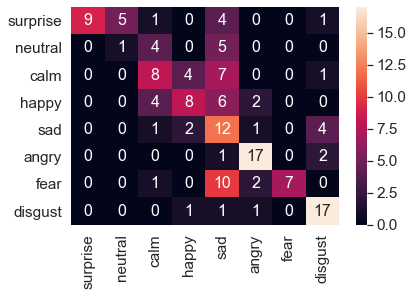

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [ ]:
correlation between emotion intensity and prediction

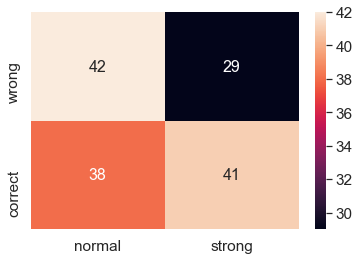

In [34]:
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [ ]:
correlation between gender and corectness

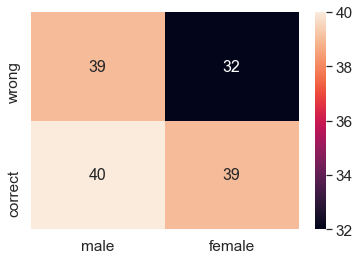

In [35]:
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

## Plot loss

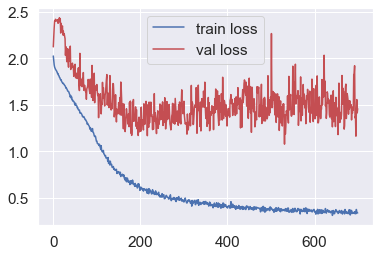

In [36]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])